In [1]:
import torch
import torch.backends
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader, random_split
from dataset import Fish_dataset
from Model import yolo_fish
from Loss import YoloLoss
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
    train_step,
    test_step,
    eval_model,
)
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os

if os.name == 'nt':  # For Windows
    if os.getcwd().split("\\")[-1] != "Legeplads":
        os.chdir('../..')
else:  # For Unix and Linux
    if os.getcwd().split('/')[-1] != 'Legeplads':
        os.chdir('../..')

os.getcwd()

'/Users/markus/Documents/Legeplads'

## Hyperparameters

In [2]:
# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 1000
NUM_WORKERS = 0 # Test hvad de gør med cuda
PIN_MEMORY = False # Test hvad de gør med cuda
LOAD_MODEL = True
LOAD_MODEL_FILE = "../overfit.pth.tar"

In [6]:
#########################################################################
# Set seed for reproducibility
seed = 123
torch.manual_seed(seed)
#########################################################################
# Load Data
transform = transforms.Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

fish_data = Fish_dataset("Fish_model/yolo/train_file.csv",
    transform=transform,)

train_dataset, test_dataset = random_split(fish_data,[0.9,0.1],generator=torch.Generator().manual_seed(seed))

# train_dataset = Fish_dataset(
#     "Fish_model/yolo/train_file.csv",
#     transform=transform,
# )

# test_dataset = Fish_dataset(
#     "Fish_model/yolo/test_file.csv", transform=transform,
# )
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=False,
    drop_last=False,
)
#########################################################################
# Model
model1 = yolo_fish(split_size=7, num_boxes=2, num_classes=1).to(DEVICE)
optimizer = optim.Adam(
    model1.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)
loss_fn = YoloLoss()
#########################################################################
# Load Model
if LOAD_MODEL:
    loaded_model = torch.load(LOAD_MODEL_FILE, map_location=torch.device(DEVICE))
    model1.load_state_dict(loaded_model["state_dict"])
    # load_checkpoint(torch.load(LOAD_MODEL_FILE, map_location=torch.device(DEVICE)), model1, optimizer)

j

NameError: name 'j' is not defined

## Train/Test loop

In [ ]:
seed = 123
torch.manual_seed(seed)
train_loss_all = []
test_loss_all = []
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}")
    # Train
    train_loss = train_step(model1,train_loader,loss_fn,optimizer,DEVICE)
    train_loss_all.append(train_loss)

    # # Test
    # test_loss = test_step(model1,test_loader,loss_fn,DEVICE)
    # test_loss_all.append(test_loss)

    # pred_boxes, target_boxes = get_bboxes(train_loader, 
    #                                       model1, 
    #                                       iou_threshold=0.5, 
    #                                       threshold=0.4, device=DEVICE
    #     )

    # mean_avg_prec = mean_average_precision(pred_boxes, 
    #                                        target_boxes, 
    #                                        iou_threshold=0.5, 
    #                                        box_format="midpoint"
    #     )
    # print(f"Train mAP: {mean_avg_prec}")


    # if mean_avg_prec > 0.9999999:
    #     checkpoint = {
    #            "state_dict": model1.state_dict(),
    #            "optimizer": optimizer.state_dict(),
    #     }
    #     save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)

## Save model

In [ ]:
save_checkpoint(model=model1,optimizer=optimizer ,filename=LOAD_MODEL_FILE)

## eval model

In [10]:
seed = 123
torch.manual_seed(seed)
with torch.inference_mode():
        pred_boxes, target_boxes = get_bboxes(test_loader, model1, iou_threshold=0.5, threshold=0.5, device=DEVICE, seed=seed)

        mean_avg_prec = mean_average_precision(pred_boxes, 
                                                target_boxes, 
                                                iou_threshold=0.5, 
                                                box_format="midpoint"
                )
        print(f"Train mAP: {mean_avg_prec}")

Train mAP: 0.024999987334012985


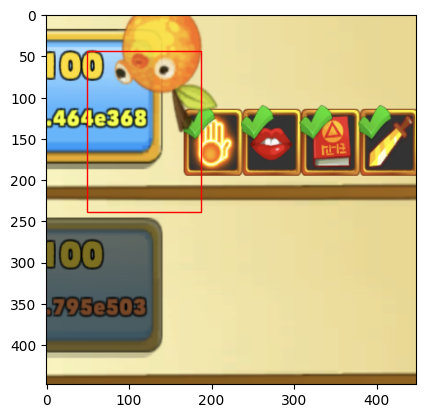

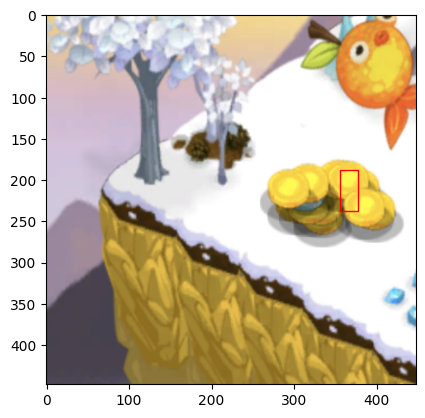

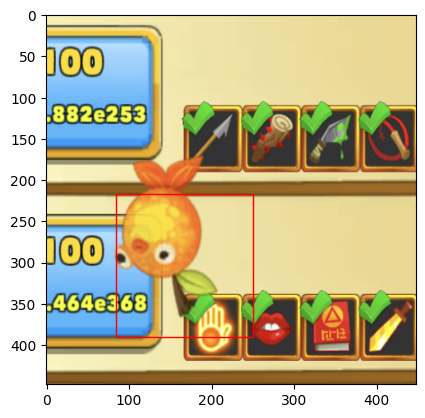

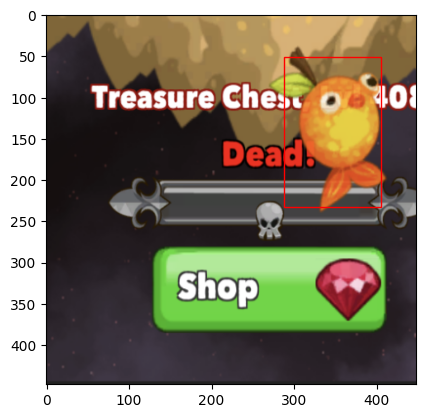

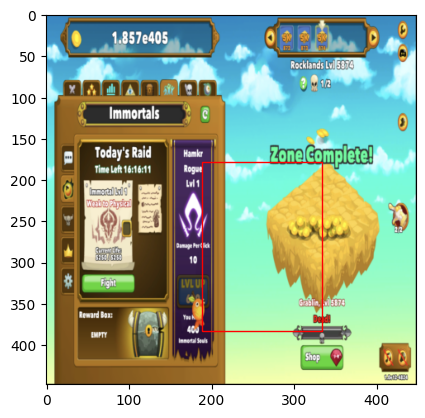

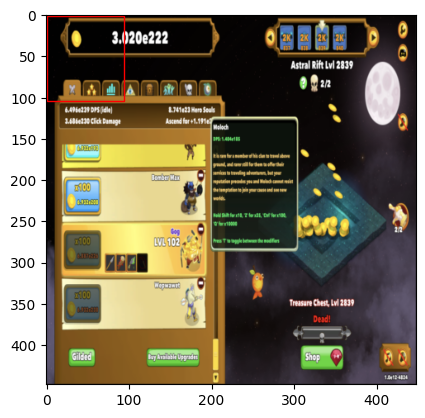

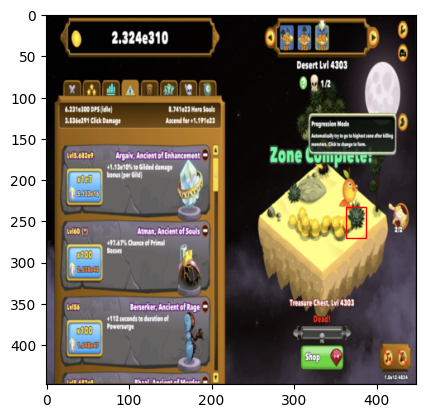

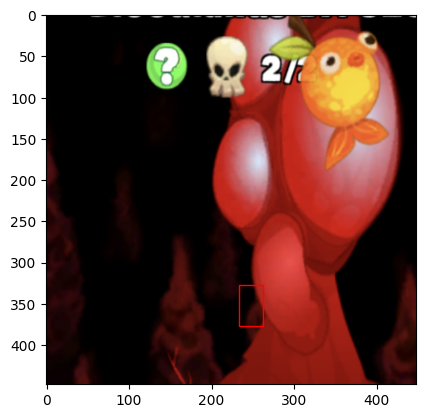

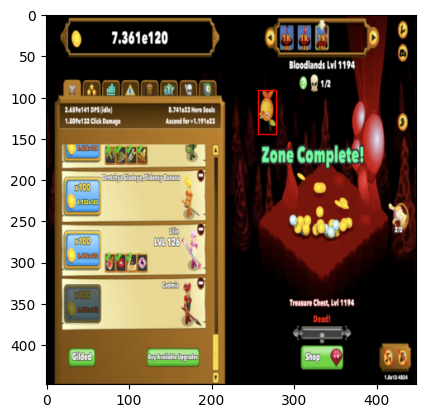

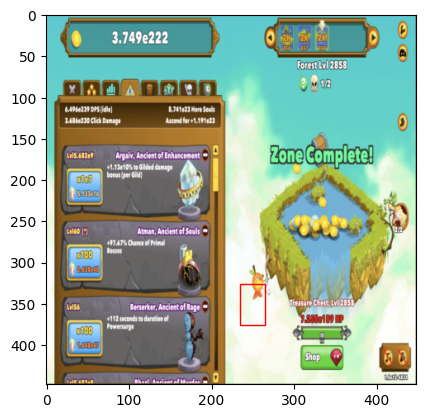

In [9]:
seed = 123
torch.manual_seed(seed)

for batch_idx,(x, _) in enumerate(test_loader):
        batch_size = x.shape[0]
        for idx in range(batch_size):
                plot_image(x[idx].permute(1,2,0).to("cpu"),[pred_boxes[idx+batch_idx*batch_size][1:],])
        